In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

GENERATE_PNGS = True
pd.options.display.float_format = '{:.1f}'.format

## Preprocessing

In [57]:
def preprocess_matlab(filepath: str):
	mname = filepath[filepath.rindex('_')+1:filepath.rindex('.')]
	matlab = pd.read_csv(filepath, usecols=('Epoch', 'TimeSinceStart', 'TrainingLoss', 'ValidationAccuracy', 'State'))
	matlab = matlab.rename(columns=dict(zip(matlab.columns, ['epoch','elapsed_time','loss','performance','type'])))

	matlab.insert(0, 'type', matlab.pop('type'))
	matlab.insert(4, 'elapsed_time', matlab.pop('elapsed_time'))

	matlab.loss = matlab.loss.fillna(-1)
	matlab = matlab.dropna(axis=0)
	matlab.insert(0, 'model_name', mname)

	# matlab.elapsed_time *= 1e3
	matlab = matlab[matlab.type != 'done'].drop([1])
	matlab = matlab.reset_index().drop('index', axis=1)
	matlab.type = matlab.type.replace('iteration', 'training')
	matlab.loc[1:7, 'elapsed_time'] = matlab.elapsed_time[1:-1] - matlab.elapsed_time.shift(1)[1:-1]

	return matlab

fcnet = preprocess_matlab('../results_def/matlab_FullyConnectedNet.csv')
scvnet = preprocess_matlab('../results_def/matlab_SimpleConvNet.csv')
mnet = preprocess_matlab('../results_def/matlab_MobileNet-v2.csv')

matlab = pd.concat([fcnet, scvnet, mnet])
matlab.to_csv('../results_def/matlab.csv', index=False)

In [58]:
pytorch = pd.read_csv('../results_def/pytorch.csv')
pytorch = pytorch[pytorch.type == 'training']
pytorch.insert(0, 'framework', 'PyTorch')
# kinda counterintuitive, but where changes values where the condition is false
pytorch.elapsed_time.where(pytorch.model_name != 'DCGAN', pytorch.elapsed_time / 1000000000, inplace=True)
pytorch.elapsed_time.where(pytorch.model_name == 'DCGAN', pytorch.elapsed_time / 1000, inplace=True)

libtorch = pd.read_csv('../results_def/libtorch.csv')
libtorch = libtorch[(libtorch.type == 'training') | (libtorch.type == 'read')]
libtorch.insert(0, 'framework', 'LibTorch')
libtorch.elapsed_time.where(libtorch.model_name != 'CELEBA', libtorch.elapsed_time / 1000000, inplace=True)
libtorch.elapsed_time.where(libtorch.model_name == 'CELEBA', libtorch.elapsed_time / 1000, inplace=True)

tensorflow = pd.read_csv('../results_def/tensorflow.csv')
tensorflow = tensorflow[tensorflow.type == 'training']
tensorflow.insert(0, 'framework', 'TensorFlow')
tensorflow.elapsed_time /= 1000000000

cudnn = pd.read_csv('../results_def/cudnn.csv')
cudnn = cudnn[cudnn.type == 'training']
cudnn.insert(0, 'framework', 'cuDNN')
cudnn.elapsed_time /= 1000

matlab = pd.read_csv('../results_def/matlab.csv')
matlab = matlab[matlab.type == 'training']
matlab.insert(0, 'framework', 'Matlab')

training = pd.concat([pytorch, tensorflow, libtorch, cudnn, matlab])
training.drop(columns=['type', 'loss', 'performance'], inplace=True)
training.reset_index(drop=True, inplace=True)

In [59]:
pytorch = pd.read_csv('../results_def/pytorch.csv')
pytorch = pytorch[pytorch.type != 'training']
pytorch.insert(0, 'framework', 'PyTorch')
pytorch.elapsed_time.where(pytorch.model_name != 'DCGAN', pytorch.elapsed_time / 1000000, inplace=True)
pytorch

libtorch = pd.read_csv('../results_def/libtorch.csv')
libtorch = libtorch[(libtorch.type != 'training') & (libtorch.type != 'read')]
libtorch.insert(0, 'framework', 'LibTorch')

tensorflow = pd.read_csv('../results_def/tensorflow.csv')
tensorflow = tensorflow[tensorflow.type != 'training']
tensorflow.insert(0, 'framework', 'TensorFlow')
tensorflow.elapsed_time /= 1000000

cudnn = pd.read_csv('../results_def/cudnn.csv')
cudnn = cudnn[cudnn.type != 'training']
cudnn.insert(0, 'framework', 'cuDNN')

matlab = pd.read_csv('../results_def/matlab.csv')
matlab = matlab[matlab.type != 'training']
matlab.insert(0, 'framework', 'Matlab')
matlab.elapsed_time *= 1000

evaluation = pd.concat([pytorch, tensorflow, libtorch, cudnn, matlab])
evaluation.drop(columns=['type', 'loss', 'performance', 'epoch'], inplace=True)
evaluation.reset_index(drop=True, inplace=True)

### LibTorch: native and imported models

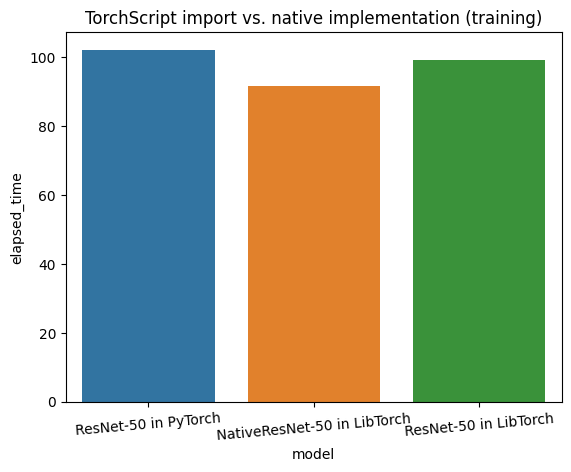

In [60]:
fig, ax = plt.subplots(1,1)

resnet = training[(training.model_name == 'ResNet-50') | (training.model_name == 'NativeResNet-50')]
resnet = resnet[resnet.framework != 'TensorFlow']
resnet = resnet[resnet.epoch == 5].drop(columns=['epoch'])
resnet['model'] = resnet.pop('model_name') + ' in ' + resnet.pop('framework')

sns.barplot(data=resnet, x='model', y='elapsed_time', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=5)
ax.set_title('TorchScript import vs. native implementation (training)')

if GENERATE_PNGS:
	fig.savefig('./plots/libtorch_native_vs_imported_train.png')

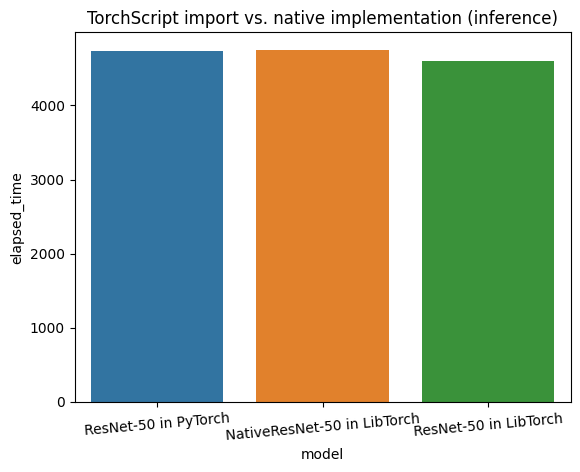

In [61]:
fig, ax = plt.subplots(1,1)

resnet = evaluation[(evaluation.model_name == 'ResNet-50') | (evaluation.model_name == 'NativeResNet-50')]
resnet = resnet[resnet.framework != 'TensorFlow']
resnet['model'] = resnet.pop('model_name') + ' in ' + resnet.pop('framework')

sns.barplot(data=resnet, x='model', y='elapsed_time', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=5)
ax.set_title('TorchScript import vs. native implementation (inference)')

if GENERATE_PNGS:
	fig.savefig('./plots/libtorch_native_vs_imported_infer.png')

### Classification: LibTorch vs PyTorch
* dlaczego libtorch nie jest duzo szybszy od pytorcha? dla szkolenia jeszcze rozumiem, ale dla inferencji? przeciez libtorcha wykorzystuje sie wlasnie gdzie potrzeba jest low latency  
* dlaczego scvnet w pytorchu ssie tak bardzo? juz nawet nie w porownaniu z tf tylko nawet z libtorchem, a to przeciez ta sama architektura na tym samym silniku obliczeniowym

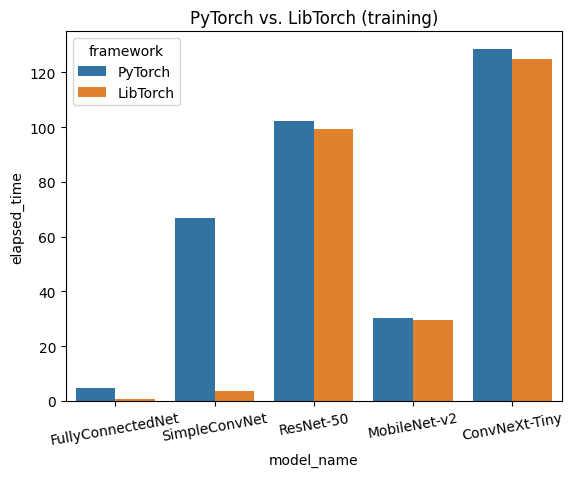

In [62]:
fig, ax = plt.subplots(1,1)

clfs = training[(training.framework == 'PyTorch') | (training.framework == 'LibTorch')] 
clfs = clfs[clfs.model_name != 'NativeResNet-50']
clfs = clfs[clfs.epoch == 5].drop(columns=['epoch'])
clfs = clfs[clfs.model_name != 'DCGAN']
sns.barplot(data=clfs, x='model_name', y='elapsed_time', hue='framework', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.set_title('PyTorch vs. LibTorch (training)')

if GENERATE_PNGS:
	fig.savefig('./plots/libtorch_vs_pytorch_clfs_train.png')

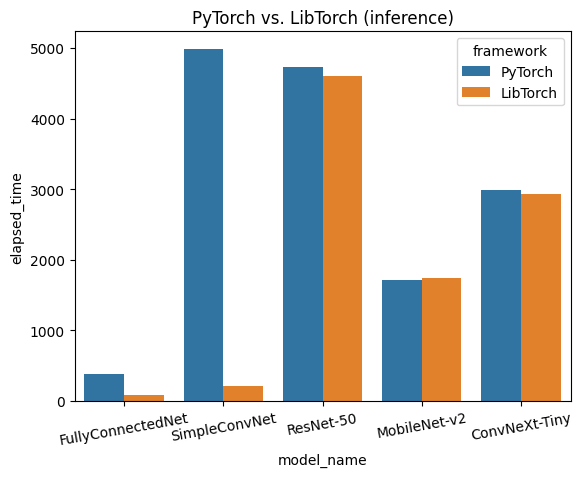

In [63]:
fig, ax = plt.subplots(1,1)

clfs = evaluation[(evaluation.framework == 'PyTorch') | (evaluation.framework == 'LibTorch')]
clfs = clfs[clfs.model_name != 'NativeResNet-50']
clfs = clfs[clfs.model_name != 'DCGAN']
sns.barplot(data=clfs, x='model_name', y='elapsed_time', hue='framework', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.set_title('PyTorch vs. LibTorch (inference)')

if GENERATE_PNGS:
	fig.savefig('./plots/libtorch_vs_pytorch_clfs_infer.png')

### Classification: Torch vs. TensorFlow

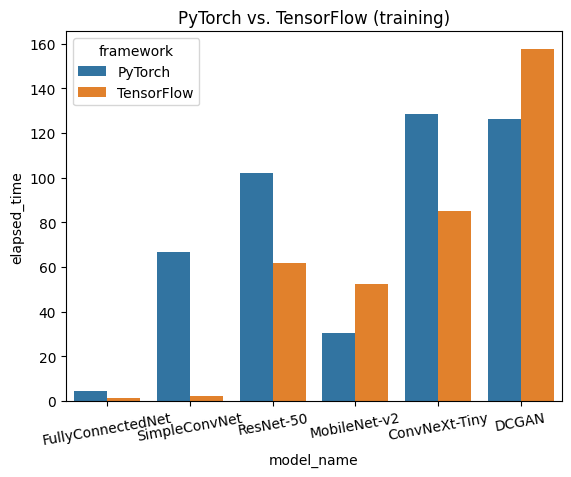

In [64]:
fig, ax = plt.subplots(1,1)

clfs = training[training.framework != 'Matlab']
clfs = clfs[clfs.framework != 'cuDNN']
clfs = clfs[clfs.framework != 'LibTorch']
clfs = clfs[clfs.model_name != 'NativeResNet-50']
clfs = clfs[clfs.epoch == 5].drop(columns=['epoch'])
# clfs = clfs[clfs.model_name != 'DCGAN']
sns.barplot(data=clfs, x='model_name', y='elapsed_time', hue='framework', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.set_title('PyTorch vs. TensorFlow (training)')

if GENERATE_PNGS:
	fig.savefig('./plots/torch_vs_tensorflow_clfs_train.png')

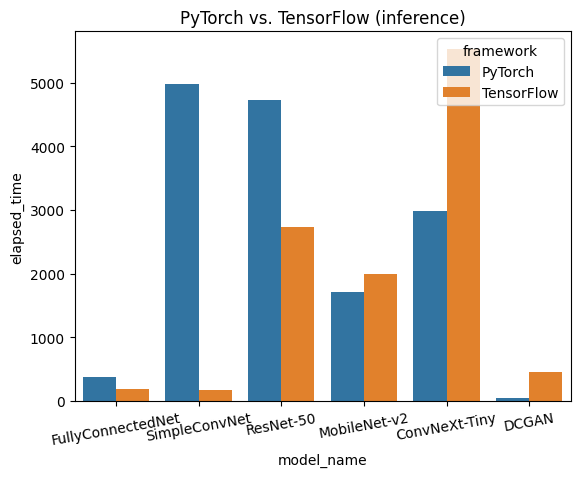

In [65]:
fig, ax = plt.subplots(1,1)

clfs = evaluation[evaluation.framework != 'Matlab']
clfs = clfs[clfs.framework != 'cuDNN']
clfs = clfs[clfs.framework != 'LibTorch']
clfs = clfs[clfs.model_name != 'NativeResNet-50']
# clfs = clfs[clfs.model_name != 'DCGAN']
sns.barplot(data=clfs, x='model_name', y='elapsed_time', hue='framework', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.set_title('PyTorch vs. TensorFlow (inference)')

if GENERATE_PNGS:
	fig.savefig('./plots/torch_vs_tensorflow_clfs_infer.png')

### LibTorch vs cuDNN: Is it worth the hassle?

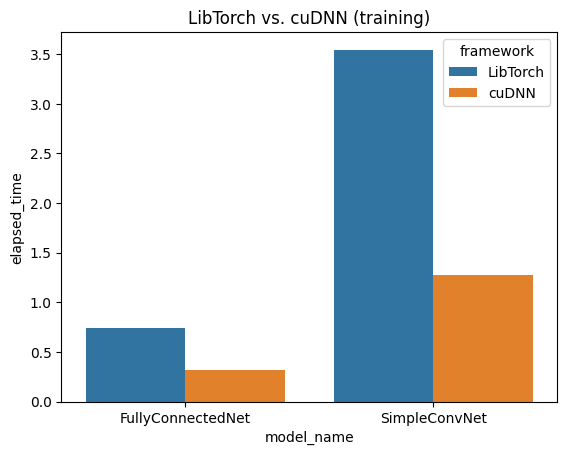

In [66]:
fig, ax = plt.subplots(1,1)

# clfs = training[(training.framework != 'Matlab') & (training.framework != 'PyTorch')]
clfs = training[(training.framework == 'cuDNN') | (training.framework == 'LibTorch')]
clfs = clfs[(clfs.model_name == 'FullyConnectedNet') | (clfs.model_name == 'SimpleConvNet')]
clfs = clfs[clfs.epoch == 5].drop(columns=['epoch'])
sns.barplot(data=clfs, x='model_name', y='elapsed_time', hue='framework', ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.set_title('LibTorch vs. cuDNN (training)')

if GENERATE_PNGS:
	fig.savefig('./plots/cudnn_train.png')

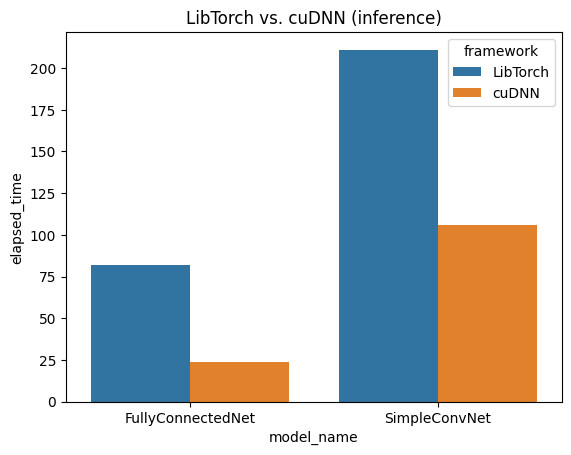

In [67]:
fig, ax = plt.subplots(1,1)

# clfs = training[(training.framework != 'Matlab') & (training.framework != 'PyTorch')]
clfs = evaluation[(evaluation.framework == 'cuDNN') | (evaluation.framework == 'LibTorch')]
clfs = clfs[(clfs.model_name == 'FullyConnectedNet') | (clfs.model_name == 'SimpleConvNet')]
sns.barplot(data=clfs, x='model_name', y='elapsed_time', hue='framework', ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.set_title('LibTorch vs. cuDNN (inference)')

if GENERATE_PNGS:
	fig.savefig('./plots/cudnn_infer.png')

### Matlab

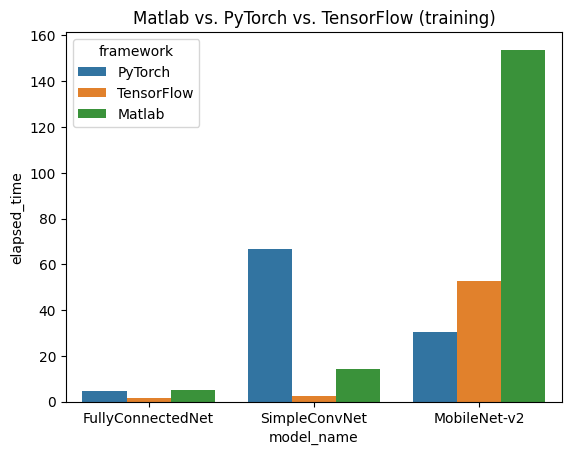

In [68]:
fig, ax = plt.subplots(1,1)

clfs = training[(training.framework != 'LibTorch') & (training.framework != 'cuDNN')]
clfs = clfs[clfs.epoch == 2].drop(columns=['epoch'])
clfs = clfs[(clfs.model_name == 'FullyConnectedNet') | (clfs.model_name == 'MobileNet-v2') | (clfs.model_name == 'SimpleConvNet')]
sns.barplot(data=clfs, x='model_name', y='elapsed_time', hue='framework', ax=ax)
ax.set_title('Matlab vs. PyTorch vs. TensorFlow (training)')

if GENERATE_PNGS:
	fig.savefig('./plots/matlab_train.png')

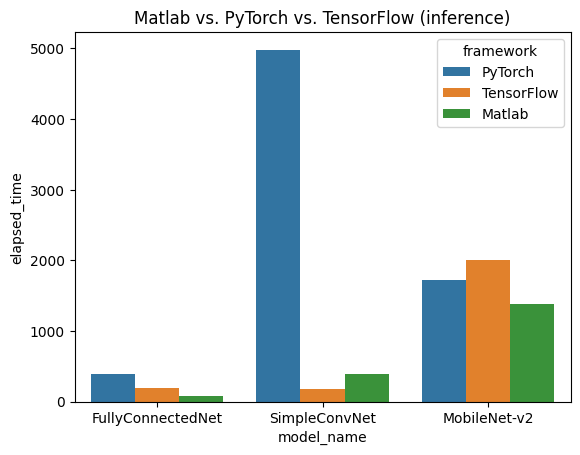

In [69]:
fig, ax = plt.subplots(1,1)

clfs = evaluation[(evaluation.framework != 'LibTorch') & (evaluation.framework != 'cuDNN')]
clfs = clfs[(clfs.model_name == 'FullyConnectedNet') | (clfs.model_name == 'MobileNet-v2') | (clfs.model_name == 'SimpleConvNet')]
sns.barplot(data=clfs, x='model_name', y='elapsed_time', hue='framework', ax=ax)
ax.set_title('Matlab vs. PyTorch vs. TensorFlow (inference)')

if GENERATE_PNGS:
	fig.savefig('./plots/matlab_infer.png')

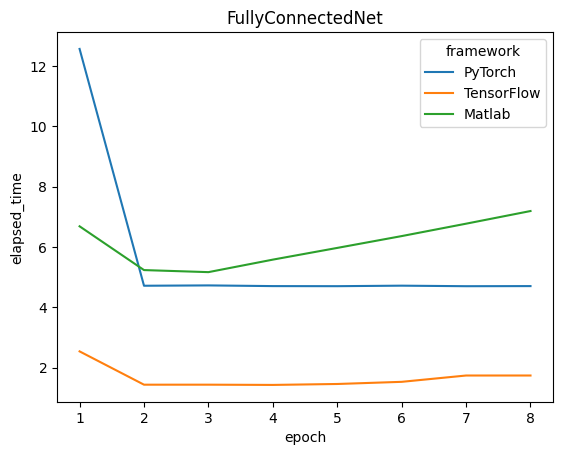

In [70]:
fig, ax = plt.subplots(1,1)

clfs = training[(training.framework != 'LibTorch') & (training.framework != 'cuDNN')]
sns.lineplot(data=clfs[clfs.model_name == 'FullyConnectedNet'], x='epoch', y='elapsed_time', hue='framework', ax=ax)
ax.set_title('FullyConnectedNet')

if GENERATE_PNGS:
	fig.savefig('./plots/matlab_increasing_train_time.png')

### DCGAN

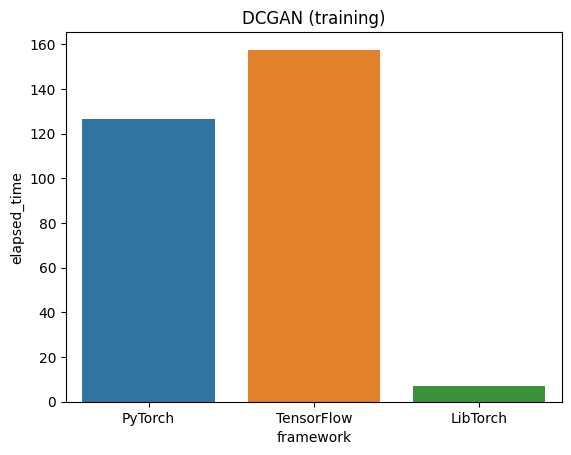

In [71]:
fig, ax = plt.subplots(1,1)

dcgan = training[training.model_name == 'DCGAN']
dcgan = dcgan[dcgan.epoch == 5].drop(columns=['epoch'])
sns.barplot(data=dcgan, x='framework', y='elapsed_time', ax=ax)
ax.set_title('DCGAN (training)')

if GENERATE_PNGS:
	fig.savefig('./plots/dcgan_comparison.png')

Text(0.5, 1.0, 'DCGAN (training + data loading)')

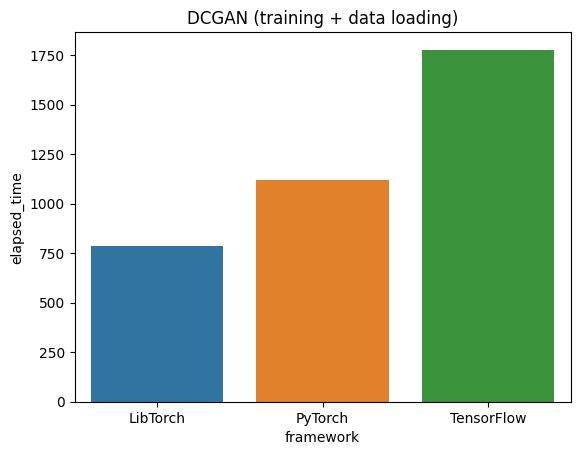

In [72]:
dcgan = training[training.model_name == 'DCGAN'].groupby('framework')['elapsed_time'].sum()
dcgan['LibTorch'] += training.loc[training.model_name == 'CELEBA', 'elapsed_time'].sum()
dcgan = dcgan.to_frame().reset_index()

fig, ax = plt.subplots(1,1)
sns.barplot(data=dcgan, x='framework', y='elapsed_time', ax=ax)
ax.set_title('DCGAN (training + data loading)')

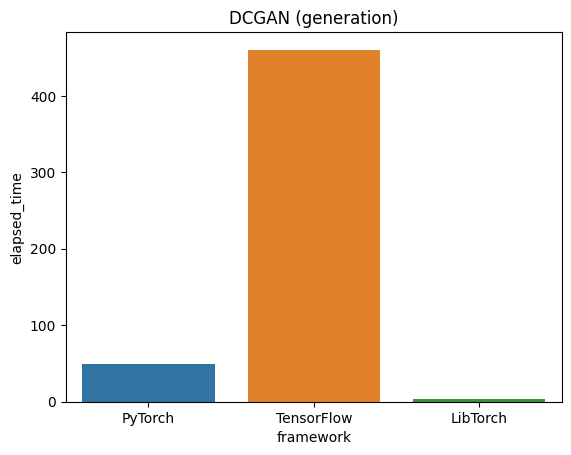

In [73]:
fig, ax = plt.subplots(1,1)

dcgan = evaluation[evaluation.model_name == 'DCGAN']
sns.barplot(data=dcgan, x='framework', y='elapsed_time', ax=ax)
ax.set_title('DCGAN (generation)')

if GENERATE_PNGS:
	fig.savefig('./plots/dcgan_gen_comp.png')